treeple1 environment

In [1]:
import ydf

In [2]:
import treeple
from treeple.datasets import make_trunk_classification
import pandas as pd
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

def train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=500):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

In [5]:
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 1.0

params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure
params_ydf["max_num_nodes"] = None
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "BINARY"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "NONE" #"MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

In [7]:
n_samples=2000
num_dim=10
X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_train = prepare_dataframe(X_train, y_train)
df_test = prepare_dataframe(X_test, y_test)

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


In [8]:
learner = ydf.RandomForestLearner(**params_ydf)
start_time = time.time()
ydf_model = learner.train(df_train)
time_ydf = time.time() - start_time
pred_ydf = ydf_model.predict(df_test)
pred_ydf = (pred_ydf >= 0.5).astype(int) 

acc_ydf = accuracy_score(y_test, pred_ydf)
acc_ydf

Train model on 1600 examples
Model trained in 0:00:00.134992


0.745

In [9]:
learner.hyperparameter_templates()

{'better_defaultv1': HyperparameterTemplate(name='better_default', version=1, parameters={'winner_take_all': True}, description='A configuration that is generally better than the default parameters without being more expensive.'),
 'benchmark_rank1v1': HyperparameterTemplate(name='benchmark_rank1', version=1, parameters={'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')}

In [39]:
ydf_model.describe()

In [9]:
ydf_model.save("saved_model/")

In [17]:
import re
import numpy as np
from scipy.sparse import lil_matrix

def extract_projections(tree_str):
    
    attr_blocks = re.findall(r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]', tree_str)
    print(len(attr_blocks))
    projection_rows = []
    max_feature_index = -1

    for attr_str, weight_str in attr_blocks:
        print(attr_str)
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        # Track the maximum feature index
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))

    # Projection dimension = max feature index + 1
    proj_dim = max_feature_index + 1

    # Initialize sparse projection matrix
    projection_matrix = lil_matrix((len(projection_rows), proj_dim))
    for i, (attrs, weights) in enumerate(projection_rows):
        for j, attr in enumerate(attrs):
            projection_matrix[i, attr] = weights[j]

    return projection_matrix, proj_dim


In [ ]:


def selected_weights(tree_str, n_feature):
    """
    Parses a string representation of a YDF decision tree to extract the projection matrix,
    compute its dimension (number of input features), and count non-zero weights.

    Args:
        tree_str (str): Stringified tree structure starting from the root node.

    Returns:
        weight_at_nodes (scipy.sparse.lil_matrix): Sparse matrix of projections.
        proj_dim (int): Dimensionality of each projection (i.e., number of input features).
        num_nonzeros (int): Total number of non-zero weights in the matrix.
    """
    # Find all attribute-weight pairs
    attr_blocks = re.findall(
        r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]',
        tree_str
    )
    # print("num of dense vectors: ", len(attr_blocks))

    projection_rows = []
    max_feature_index = -1
    total_nonzeros = 0

    for attr_str, weight_str in attr_blocks:
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        total_nonzeros += len(weights)  # Count all weights (assumed non-zero)
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))
    print(projection_rows)

    
    weight_at_nodes = np.zeros((len(attr_blocks), n_feature))

    for i in range(len(projection_rows)):
        attr = projection_rows[i][0]
        print(attr)
        weight = projection_rows[i][1]
        for j in range(len(weight)):
            weight_at_nodes[i, attr[j]-1] = weight[j]

    return weight_at_nodes, total_nonzeros


## Do a pipline

In [35]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 300,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'in_split_min_examples_check': True,
 'min_examples': 1,
 'keep_non_leaf_label_distribution': True,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes_ratio': 1.0,
 'sorting_strategy': 'IN_NODE',
 'split_axis': 'SPARSE_OBLIQUE',
 'sparse_oblique_weights': 'BINARY',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'NONE',
 'sparse_oblique_max_num_projections': 100,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

In [123]:
def get_ydf_model(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                    max_feature=100, feature_combination=3.0, exponent=1.0, X=None, y=None):
    if X is None or y is None:
        X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time
    return ydf_model, time_taken

In [59]:

def selected_weights(tree_str, n_feature):
    """
    Parses a string representation of a YDF decision tree to extract the projection matrix,
    compute its dimension (number of input features), and count non-zero weights.

    Args:
        tree_str (str): Stringified tree structure starting from the root node.

    Returns:
        weight_at_nodes (scipy.sparse.lil_matrix): Sparse matrix of projections.
        proj_dim (int): Dimensionality of each projection (i.e., number of input features).
        num_nonzeros (int): Total number of non-zero weights in the matrix.
    """
    # Find all attribute-weight pairs
    attr_blocks = re.findall(
        r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]',
        tree_str
    )
    # print("num of dense vectors: ", len(attr_blocks))

    projection_rows = []
    max_feature_index = -1
    total_nonzeros = 0

    for attr_str, weight_str in attr_blocks:
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        total_nonzeros += len(weights)  # Count all weights (assumed non-zero)
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))
    #print(projection_rows)

    
    weight_at_nodes = np.zeros((len(attr_blocks), n_feature))

    for i in range(len(projection_rows)):
        attr = projection_rows[i][0]
        #print(attr)
        weight = projection_rows[i][1]
        for j in range(len(weight)):
            weight_at_nodes[i, attr[j]-1] = weight[j]

    return weight_at_nodes, total_nonzeros


In [135]:
# count number of oblique nodes
def count_oblique_nodes(node):
    if isinstance(node, ydf.tree.Leaf):
        return 0

    count = 0
    if isinstance(node.condition, ydf.tree.NumericalSparseObliqueCondition):
        count += 1

    count += count_oblique_nodes(node.neg_child)
    count += count_oblique_nodes(node.pos_child)
    return count

def get_ydf_tree_weights(ydf_root, n_feature):
    root_str = str(ydf_root)
    weight_at_nodes, num_nonzeros = selected_weights(root_str, n_feature)
    return weight_at_nodes, num_nonzeros


def get_ydf_tree_info(root_node):
    if isinstance(root_node, ydf.tree.Leaf):
        return 1, 1, 0  # max_depth, num_nodes, num_oblique_nodes

    left_depth, left_nodes, left_oblique = get_ydf_tree_info(root_node.neg_child)
    right_depth, right_nodes, right_oblique = get_ydf_tree_info(root_node.pos_child)

    max_depth = 1 + max(left_depth, right_depth)
    total_nodes = 1 + left_nodes + right_nodes
    oblique_nodes = count_oblique_nodes(root_node) 

    return max_depth, total_nodes, oblique_nodes


##
n_dim=50
ydf_model, time_taken = get_ydf_model(params_ydf, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                    max_feature=100, feature_combination=3.0, exponent=1.0)
tree = ydf_model.get_tree(1)
max_depth, node_count, oblique_count = get_ydf_tree_info(tree.root)
weight_at_nodes, num_nonzeros = get_ydf_tree_weights(tree.root, n_dim)
print("Max depth:", max_depth)
print("Total number of nodes:", node_count)
print("Number of oblique nodes:", oblique_count)
print("weight_at_nodes:", weight_at_nodes)
print("weight_at_nodes shape:", weight_at_nodes.shape)
print("time taken:", time_taken)

Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.212025
Max depth: 8
Total number of nodes: 61
Number of oblique nodes: 30
weight_at_nodes: [[-1.  0.  0. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]]
weight_at_nodes shape: (30, 50)
time taken: 0.21602606773376465


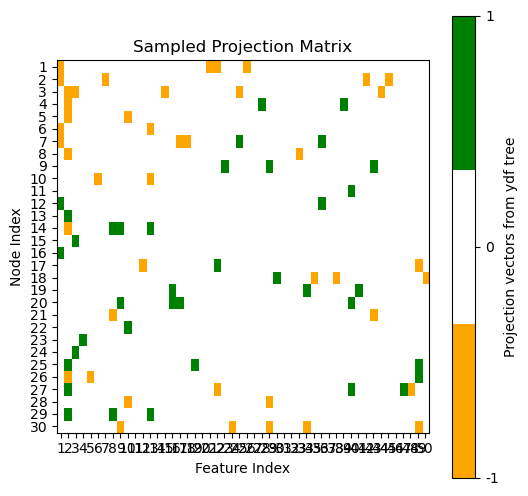

In [93]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

# Visualize the projection matrix
cmap = ListedColormap(["orange", "white", "green"])

# Create a heatmap to visualize the indices
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(weight_at_nodes, cmap=cmap, aspect=n_dim / oblique_count, interpolation="none")

ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Node Index")
ax.set_xticks(np.arange(n_dim))
ax.set_yticks(np.arange(oblique_count))
ax.set_yticklabels(np.arange(oblique_count, dtype=int) + 1)
ax.set_xticklabels(np.arange(n_dim, dtype=int) + 1)

# Create a mappable object
sm = ScalarMappable(cmap=cmap)
sm.set_array([])  # You can set an empty array or values here

# Create a color bar with labels for each feature set
colorbar = fig.colorbar(sm, ax=ax, ticks=[0, 0.5, 1], format="%d")
colorbar.set_label("Projection vectors from ydf tree")
colorbar.ax.set_yticklabels(["-1", "0", "1"])

plt.show()

### older version

In [194]:
def extract_projections_pipline(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                                max_feature=100, feature_combination=3.0, exponent=1.0,
                                tree_id=0):
    
    X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time

    root_str = str(ydf_model.get_tree(tree_id).root)
    print("*",root_str)
    projection_matrix, proj_dim, n_nonzeros = extract_projections(root_str)

    print("nonzeros number:", n_nonzeros)
    print("projection matrix shape:", projection_matrix.shape)

    return projection_matrix, proj_dim, n_nonzeros, time_taken, ydf_model

get average n_nonzeros

In [215]:
def extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                                max_feature=100, feature_combination=3.0, exponent=1.0):
    X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time

    non_zeros = np.zeros((n_estimator,))
    proj_dim1 = np.zeros((n_estimator,))
    proj_dim2 = np.zeros((n_estimator,))
    for tree_id in range(n_estimator):
        root_str = str(ydf_model.get_tree(tree_id).root)
        #print("*",root_str)
        projection_matrix, proj_dim, n_nonzeros = extract_projections(root_str)

        non_zeros[tree_id] = n_nonzeros
        proj_dim1[tree_id] = projection_matrix.shape[0]
        proj_dim2[tree_id] = projection_matrix.shape[1]

    avg_non_zeros = np.mean(non_zeros)
    avg_proj_dim1 = np.mean(proj_dim1)
    avg_proj_dim2 = np.mean(proj_dim2)
    print("Average projection matrix shape:", avg_proj_dim1, avg_proj_dim2)
    print("Average nonzeros number:", avg_non_zeros)

    return avg_proj_dim1, avg_proj_dim2, avg_non_zeros, time_taken, ydf_model

In [228]:
_,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=100,
                                max_feature=10, feature_combination=3.0, exponent=10.0)

Train model on 1600 examples
Model trained in 0:00:00.012003
Average projection matrix shape: 30.0 100.34
Average nonzeros number: 90.14


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


In [240]:
_,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=2,
                                max_feature=20, feature_combination=0.1, exponent=1.0)

Train model on 1600 examples
Model trained in 0:00:00.014001
Average projection matrix shape: 30.0 3.0
Average nonzeros number: 30.09


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 2. Setting n_informative to n_dim.
  warnings.warn(


In [241]:
projection_matrix, proj_dim, n_nonzeros, time_taken, ydf_model = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=50, 
                                                max_feature=100, 
                                                feature_combination=3.0,
                                                tree_id=10)
#projection_matrix.shape

Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.249013
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04539964348077774, attributes=[1, 22, 24, 36], weights=[1.0, 1.0, 1.0, -1.0], threshold=0.20489168167114258), pos_child=NonLeaf(value=ProbabilityValue(num_examples=945.0, probability=[0.37566137566137564, 0.6243386243386243]), condition=NumericalSparseObliqueCondition(missing=False, score=0.05753398314118385, attributes=[2, 4, 19, 25], weights=[1.0, 1.0, 1.0, 1.0], threshold=1.6286503076553345), pos_child=NonLeaf(value=ProbabilityValue(num_examples=384.0, probability=[0.18229166666666666, 0.8177083333333334]), condition=NumericalSparseObliqueCondition(missing=False, score=0.027746761217713356, attributes=[1, 25, 37, 40], weights=[-1.0, -1.0, -1.0, -1.0], threshold=-0.22032347321510315), pos_child=Leaf(value=ProbabilityValue(num_examples=61.0, probability=[0.4098360655737705, 0.5901639344262295])), neg_child=NonLe

In [246]:
ydf_model.get_tree(10).root.pos_child.condition

NumericalSparseObliqueCondition(missing=False, score=0.05753398314118385, attributes=[2, 4, 19, 25], weights=[1.0, 1.0, 1.0, 1.0], threshold=1.6286503076553345)

In [253]:
avg_nonzero_element_num = np.zeros((5,))
for i in range(1, 5):
    print("==========")
    print("feature combination = ", i)
    _,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=100,
                                max_feature=20, feature_combination=float(i), exponent=2.0)
    avg_nonzero_element_num[i] = avg_non_zeros/30
    #print("nonzeros number:", n_nonzeros)
    #print("projection matrix shape:", projection_matrix.shape)

feature combination =  1
Train model on 1600 examples
Model trained in 0:00:00.099124
Average projection matrix shape: 30.0 96.65
Average nonzeros number: 42.12
feature combination =  2
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(
c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.133806
Average projection matrix shape: 30.0 99.22
Average nonzeros number: 65.1
feature combination =  3
Train model on 1600 examples
Model trained in 0:00:00.096644
Average projection matrix shape: 30.0 99.98
Average nonzeros number: 91.22
feature combination =  4
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(
c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.096125
Average projection matrix shape: 30.0 100.44
Average nonzeros number: 120.87


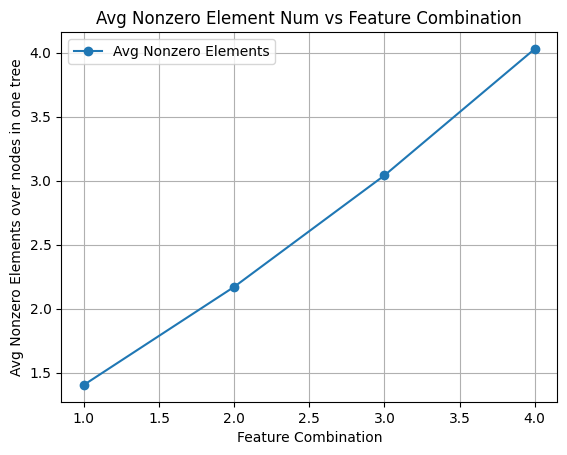

In [255]:
import matplotlib.pyplot as plt

feature_combinations = range(1, 5)  # Corresponding to the feature combination values used
plt.plot(feature_combinations, avg_nonzero_element_num[1:], marker='o', label='Avg Nonzero Elements')
plt.xlabel('Feature Combination')
plt.ylabel('Avg Nonzero Elements over nodes in one tree')
plt.title('Avg Nonzero Element Num vs Feature Combination')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
projection_matrix, proj_dim, _, _, _ = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=100, 
                                                feature_combination=3.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.827913
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.010048951022326946, attributes=[7, 56, 721, 783], weights=[1.0, 1.0, 1.0, -1.0], threshold=-0.30478930473327637), pos_child=NonLeaf(value=ProbabilityValue(num_examples=1015.0, probability=[0.4463054187192118, 0.5536945812807882]), condition=NumericalSparseObliqueCondition(missing=False, score=0.019703904166817665, attributes=[3, 552], weights=[1.0, -1.0], threshold=0.25874432921409607), pos_child=NonLeaf(value=ProbabilityValue(num_examples=533.0, probability=[0.3527204502814259, 0.6472795497185742]), condition=NumericalSparseObliqueCondition(missing=False, score=0.016616256907582283, attributes=[24], weights=[1.0], threshold=-0.34425655007362366), pos_child=Leaf(value=ProbabilityValue(num_examples=352.0, probability=[0.2897727272727273, 0.7102272727272727])), neg_child=NonLeaf(value=P

(30, 988)

In [ ]:
projection_matrix, proj_dim, _, _, _  = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=300, 
                                                feature_combination=1.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:02.350682
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.02640022709965706, attributes=[4], weights=[1.0], threshold=-0.0243707075715065), pos_child=NonLeaf(value=ProbabilityValue(num_examples=942.0, probability=[0.40445859872611467, 0.5955414012738853]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04424554854631424, attributes=[2], weights=[1.0], threshold=1.0494449138641357), pos_child=NonLeaf(value=ProbabilityValue(num_examples=260.0, probability=[0.17692307692307693, 0.823076923076923]), condition=NumericalSparseObliqueCondition(missing=False, score=0.07184826582670212, attributes=[1], weights=[1.0], threshold=0.3606805205345154), pos_child=Leaf(value=ProbabilityValue(num_examples=176.0, probability=[0.07386363636363637, 0.9261363636363636])), neg_child=Leaf(value=ProbabilityValue(num_examples=84.0, probability=[0.3

(30, 917)

In [ ]:
projection_matrix, proj_dim, _, _, _ = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=300, 
                                                feature_combination=1.0,
                                                exponent=100.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.036036
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0023543008137494326, attributes=[513], weights=[1.0], threshold=-0.20640619099140167), pos_child=NonLeaf(value=ProbabilityValue(num_examples=942.0, probability=[0.4713375796178344, 0.5286624203821656]), condition=NumericalSparseObliqueCondition(missing=False, score=0.01493818685412407, attributes=[6], weights=[1.0], threshold=0.8464932441711426), pos_child=NonLeaf(value=ProbabilityValue(num_examples=247.0, probability=[0.32793522267206476, 0.6720647773279352]), condition=NumericalSparseObliqueCondition(missing=False, score=0.010234867222607136, attributes=[263, 321], weights=[1.0, -1.0], threshold=-1.3090343475341797), pos_child=NonLeaf(value=ProbabilityValue(num_examples=208.0, probability=[0.3557692307692308, 0.6442307692307693]), condition=NumericalSparseObliqueCondition(missing=Fa

(30, 1001)

In [180]:
projection_matrix, proj_dim, n_nonzeros , _, sample_model = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=5, 
                                                n_dim=50, 
                                                max_feature=3, 
                                                feature_combination=1.5,
                                                exponent=1.0)
print(n_nonzeros)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.003998
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.10298066586256027, attributes=[1], weights=[1.0], threshold=0.40478795766830444), pos_child=NonLeaf(value=ProbabilityValue(num_examples=846.0, probability=[0.2895981087470449, 0.710401891252955]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0385918952524662, attributes=[3, 4, 31], weights=[1.0, 1.0, 1.0], threshold=0.25276243686676025), pos_child=NonLeaf(value=ProbabilityValue(num_examples=557.0, probability=[0.19748653500897667, 0.8025134649910234]), condition=NumericalSparseObliqueCondition(missing=False, score=0.007645494304597378, attributes=[33, 41], weights=[-1.0, -1.0], threshold=3.1825172901153564), pos_child=Leaf(value=ProbabilityValue(num_examples=5.0, probability=[0.8, 0.2])), neg_child=Leaf(value=ProbabilityValue(num_examples=552.0, probability=[0.1920

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


(30, 48)

In [259]:
sample_model.get_all_trees()[0].root

NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.10298066586256027, attributes=[1], weights=[1.0], threshold=0.40478795766830444), pos_child=NonLeaf(value=ProbabilityValue(num_examples=846.0, probability=[0.2895981087470449, 0.710401891252955]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0385918952524662, attributes=[3, 4, 31], weights=[1.0, 1.0, 1.0], threshold=0.25276243686676025), pos_child=NonLeaf(value=ProbabilityValue(num_examples=557.0, probability=[0.19748653500897667, 0.8025134649910234]), condition=NumericalSparseObliqueCondition(missing=False, score=0.007645494304597378, attributes=[33, 41], weights=[-1.0, -1.0], threshold=3.1825172901153564), pos_child=Leaf(value=ProbabilityValue(num_examples=5.0, probability=[0.8, 0.2])), neg_child=Leaf(value=ProbabilityValue(num_examples=552.0, probability=[0.19202898550724637, 0.8079710144927537]))), neg_child=NonLeaf(value=

In [ ]:
sample_model.get_all_trees()

## Let's look at treeple

In [64]:
from treeple import ObliqueRandomForestClassifier

In [71]:

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = 31
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS
#params_treeple["max_leaf_nodes"] = None

In [72]:
treeple_model = ObliqueRandomForestClassifier(**params_treeple)
treeple_model.fit(X_train, y_train)
treeple_estimators = treeple_model.estimators_

In [103]:
def get_treeple_model(params_treeple, n_sample=2000, n_estimator=100, n_dim=50, 
                    max_feature=100, feature_combination=3.0, X=None, y=None):
    if X is None:
        X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params_treeple1 = params_treeple.copy()
    params_treeple1["n_estimators"] = n_estimator
    params_treeple1["max_features"] = max_feature
    params_treeple1["feature_combinations"] = feature_combination

    treeple_model = ObliqueRandomForestClassifier(**params_treeple)
    treeple_model.fit(X_train, y_train)
    treeple_estimators = treeple_model.estimators_
    return treeple_estimators


In [153]:
def get_treeple_tree_info(treeple_estimator):
    max_depth = treeple_estimator.tree_.max_depth
    total_nodes = treeple_estimator.tree_.node_count
    leaf_nodes = treeple_estimator.tree_.n_leaves
    oblique_nodes = total_nodes - leaf_nodes
    return max_depth, total_nodes, oblique_nodes

In [154]:
# Define the n_dim settings to shuffle across
n_dim_settings = [10, 50, 100, 200]

# Iterate over each n_dim setting
for n_dim in n_dim_settings:
    print(f"=== Comparison for n_dim = {n_dim} ===")
    
    # ydf
    ydf_model, time_taken = get_ydf_model(params_ydf, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                    max_feature=100, feature_combination=3.0, exponent=1.0)
    tree = ydf_model.get_tree(1)
    ydf_max_depth, ydf_node_count, ydf_oblique_count = get_ydf_tree_info(tree.root)
    ydf_num_leaves = ydf_node_count - ydf_oblique_count

    # treeple
    treeple_estimators = get_treeple_model(params_treeple, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                           max_feature=100, feature_combination=3.0)
    treeple_max_depth, treeple_total_nodes, treeple_oblique_nodes = get_treeple_tree_info(treeple_estimators[0])
    treeple_num_leaves = treeple_total_nodes - treeple_oblique_nodes

    # Print the comparison
    print(f"YDF - Max Depth: {ydf_max_depth}, Number of Leaves: {ydf_num_leaves}, Total Nodes: {ydf_node_count}, Oblique Nodes: {ydf_oblique_count}")
    print(f"Treeple - Max Depth: {treeple_max_depth}, Number of Leaves: {treeple_num_leaves}, Total Nodes: {treeple_total_nodes}, Oblique Nodes: {treeple_oblique_nodes}")
    print()


=== Comparison for n_dim = 10 ===
Train model on 1600 examples
Model trained in 0:00:00.056993


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(
c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


YDF - Max Depth: 9, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30
Treeple - Max Depth: 8, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30

=== Comparison for n_dim = 50 ===
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.244972


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


YDF - Max Depth: 9, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30
Treeple - Max Depth: 8, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30

=== Comparison for n_dim = 100 ===
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.459543


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


YDF - Max Depth: 8, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30
Treeple - Max Depth: 7, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30

=== Comparison for n_dim = 200 ===
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.555030


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


YDF - Max Depth: 10, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30
Treeple - Max Depth: 9, Number of Leaves: 31, Total Nodes: 61, Oblique Nodes: 30



# Compare max depth between ydf and treeple

In [139]:
params_treeple

{'n_estimators': 300,
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 100,
 'max_leaf_nodes': 31,
 'min_impurity_decrease': 0.0,
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': -1,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'feature_combinations': 1.0}

In [140]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 300,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'in_split_min_examples_check': True,
 'min_examples': 1,
 'keep_non_leaf_label_distribution': True,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes_ratio': 1.0,
 'sorting_strategy': 'IN_NODE',
 'split_axis': 'SPARSE_OBLIQUE',
 'sparse_oblique_weights': 'BINARY',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'NONE',
 'sparse_oblique_max_num_projections': 100,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

In [141]:
MAX_DEPTH = 10
params_ydf["max_depth"] = MAX_DEPTH
params_treeple["max_depth"] = MAX_DEPTH
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"


Train model on 1600 examples
Model trained in 0:00:00.067991


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.326505
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.724916
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.873653
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 300. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.036026
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.129367


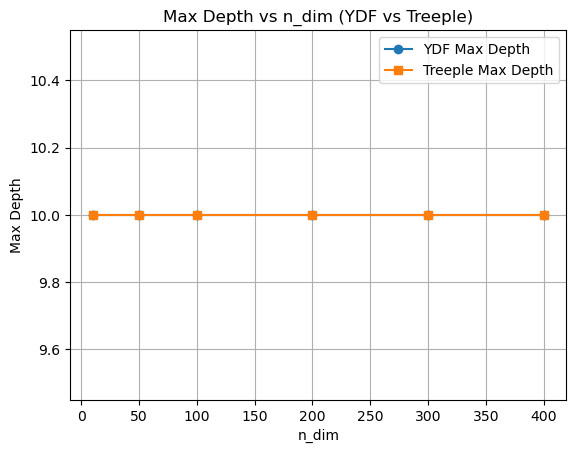

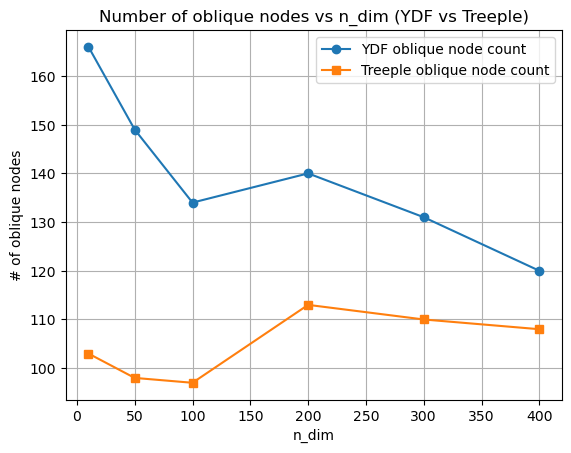

In [155]:

n_dim_settings = [10, 50, 100, 200, 300, 400]
ydf_max_depths = []
treeple_max_depths = []
ydf_node_count= []
treeple_node_count = []

# set max node to infinite
params_ydf1 = params_ydf.copy()
params_treeple1 = params_treeple.copy()
params_ydf1["max_num_nodes"] = -1
params_treeple1["max_leaf_nodes"] = None

for n_dim in n_dim_settings:
    X, y = make_trunk_classification(n_samples=2000, n_dim=n_dim, n_informative=600, seed=0)
    # ydf
    ydf_model, _ = get_ydf_model(params_ydf1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                 max_feature=100, feature_combination=3.0, exponent=1.0, X=X, y=y)  
    tree = ydf_model.get_tree(1)
    ydf_max_depth, _,ydf_oblique_count = get_ydf_tree_info(tree.root)
    ydf_max_depths.append(ydf_max_depth-1)
    ydf_node_count.append(ydf_oblique_count)

    # treeple
    treeple_estimators = get_treeple_model(params_treeple1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                           max_feature=100, feature_combination=3.0, X=X, y=y)
    treeple_max_depth, _, treeple_oblique_count = get_treeple_tree_info(treeple_estimators[0])
    treeple_max_depths.append(treeple_max_depth)
    treeple_node_count.append(treeple_oblique_count)

plt.plot(n_dim_settings, ydf_max_depths, marker='o', label='YDF Max Depth')
plt.plot(n_dim_settings, treeple_max_depths, marker='s', label='Treeple Max Depth')

plt.xlabel('n_dim')
plt.ylabel('Max Depth')
plt.title('Max Depth vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(n_dim_settings, ydf_node_count, marker='o', label='YDF oblique node count')
plt.plot(n_dim_settings, treeple_node_count, marker='s', label='Treeple oblique node count')

plt.xlabel('n_dim')
plt.ylabel('# of oblique nodes')
plt.title('Number of oblique nodes vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

Train model on 1600 examples
Model trained in 0:00:00.072988


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.311964
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.643146
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.796277
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 300. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.055443
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.119045


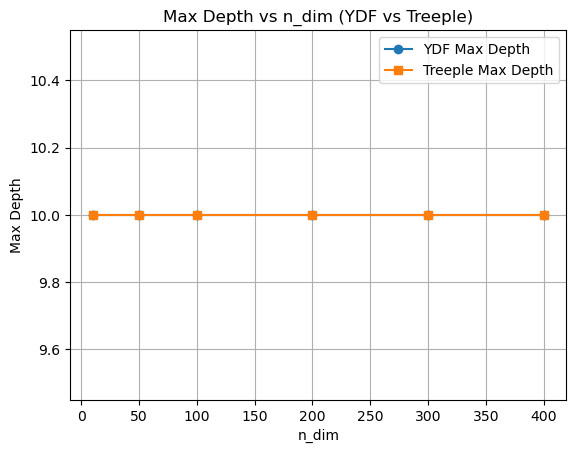

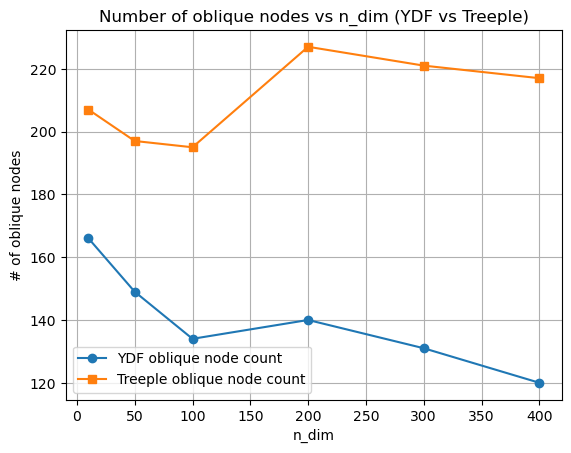

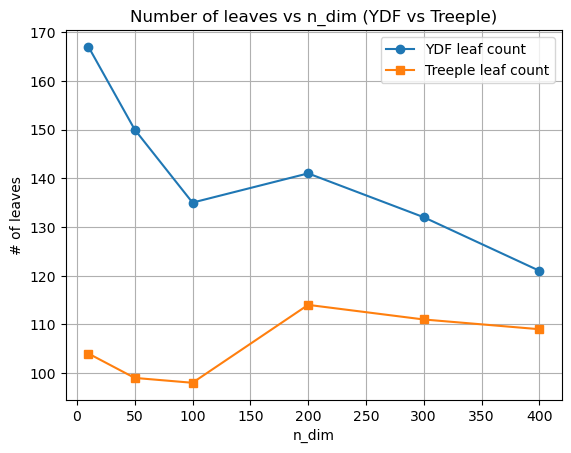

In [160]:

n_dim_settings = [10, 50, 100, 200, 300, 400]
ydf_max_depths = []
treeple_max_depths = []
ydf_node_count= []
treeple_node_count = []
treeple_leaf_count = []
ydf_leaf_count = []

# set max node to infinite
params_ydf1 = params_ydf.copy()
params_treeple1 = params_treeple.copy()
params_ydf1["max_num_nodes"] = -1
params_treeple1["max_leaf_nodes"] = None

# max nodes set to unreachable upper bound
params_ydf1["max_depth"] = 10
params_treeple1["max_depth"] = 10

for n_dim in n_dim_settings:
    X, y = make_trunk_classification(n_samples=2000, n_dim=n_dim, n_informative=600, seed=0)
    # ydf
    ydf_model, _ = get_ydf_model(params_ydf1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                 max_feature=100, feature_combination=3.0, exponent=1.0, X=X, y=y)  
    tree = ydf_model.get_tree(1)
    ydf_max_depth, ydf_num_node,ydf_num_oblique = get_ydf_tree_info(tree.root)
    ydf_max_depths.append(ydf_max_depth-1)
    ydf_node_count.append(ydf_num_oblique)
    ydf_leaf_count.append(ydf_num_node - ydf_num_oblique)

    # treeple
    treeple_estimators = get_treeple_model(params_treeple1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                           max_feature=100, feature_combination=3.0, X=X, y=y)
    treeple_max_depth, treeple_num_node, treeple_num_oblique = get_treeple_tree_info(treeple_estimators[0])
    treeple_max_depths.append(treeple_max_depth)
    treeple_node_count.append(treeple_num_node)
    treeple_leaf_count.append(treeple_num_node - treeple_num_oblique)

plt.plot(n_dim_settings, ydf_max_depths, marker='o', label='YDF Max Depth')
plt.plot(n_dim_settings, treeple_max_depths, marker='s', label='Treeple Max Depth')

plt.xlabel('n_dim')
plt.ylabel('Max Depth')
plt.title('Max Depth vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()
##
plt.plot(n_dim_settings, ydf_node_count, marker='o', label='YDF oblique node count')
plt.plot(n_dim_settings, treeple_node_count, marker='s', label='Treeple oblique node count')

plt.xlabel('n_dim')
plt.ylabel('# of oblique nodes')
plt.title('Number of oblique nodes vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

##
plt.plot(n_dim_settings, ydf_leaf_count, marker='o', label='YDF leaf count')
plt.plot(n_dim_settings, treeple_leaf_count, marker='s', label='Treeple leaf count')

plt.xlabel('n_dim')
plt.ylabel('# of leaves')
plt.title('Number of leaves vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

Train model on 1600 examples
Model trained in 0:00:00.083840


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.310966
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.703414
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.949643
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 300. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.226859
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.380034


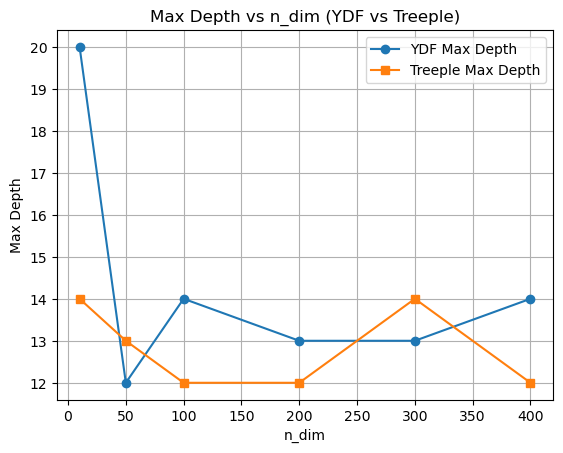

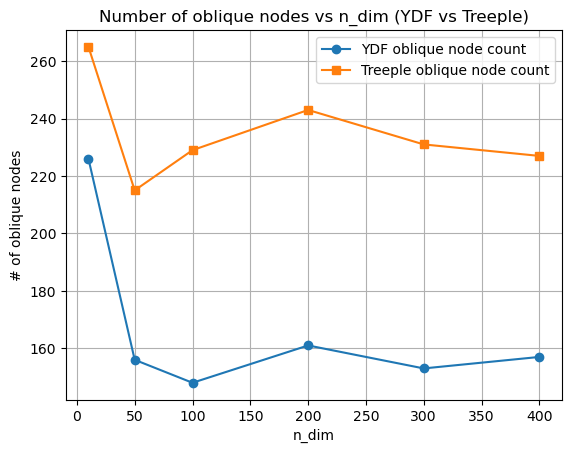

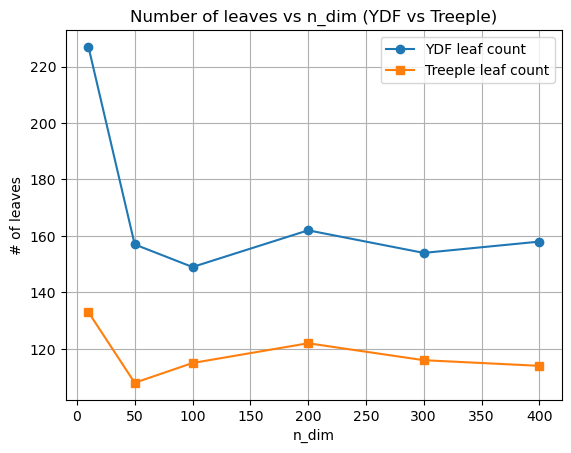

In [159]:

n_dim_settings = [10, 50, 100, 200, 300, 400]
ydf_max_depths = []
treeple_max_depths = []
ydf_node_count= []
treeple_node_count = []
treeple_leaf_count = []
ydf_leaf_count = []

# set max node to infinite
params_ydf1 = params_ydf.copy()
params_treeple1 = params_treeple.copy()
params_ydf1["max_num_nodes"] = -1
params_treeple1["max_leaf_nodes"] = None

# max nodes set to unreachable upper bound
params_ydf1["max_depth"] = 1000
params_treeple1["max_depth"] = 1000

for n_dim in n_dim_settings:
    X, y = make_trunk_classification(n_samples=2000, n_dim=n_dim, n_informative=600, seed=0)
    # ydf
    ydf_model, _ = get_ydf_model(params_ydf1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                 max_feature=100, feature_combination=3.0, exponent=1.0, X=X, y=y)  
    tree = ydf_model.get_tree(1)
    ydf_max_depth, ydf_num_node,ydf_num_oblique = get_ydf_tree_info(tree.root)
    ydf_max_depths.append(ydf_max_depth-1)
    ydf_node_count.append(ydf_num_oblique)
    ydf_leaf_count.append(ydf_num_node - ydf_num_oblique)

    # treeple
    treeple_estimators = get_treeple_model(params_treeple1, n_sample=2000, n_estimator=100, n_dim=n_dim, 
                                           max_feature=100, feature_combination=3.0, X=X, y=y)
    treeple_max_depth, treeple_num_node, treeple_num_oblique = get_treeple_tree_info(treeple_estimators[0])
    treeple_max_depths.append(treeple_max_depth)
    treeple_node_count.append(treeple_num_node)
    treeple_leaf_count.append(treeple_num_node - treeple_num_oblique)

plt.plot(n_dim_settings, ydf_max_depths, marker='o', label='YDF Max Depth')
plt.plot(n_dim_settings, treeple_max_depths, marker='s', label='Treeple Max Depth')

plt.xlabel('n_dim')
plt.ylabel('Max Depth')
plt.title('Max Depth vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()
##
plt.plot(n_dim_settings, ydf_node_count, marker='o', label='YDF oblique node count')
plt.plot(n_dim_settings, treeple_node_count, marker='s', label='Treeple oblique node count')

plt.xlabel('n_dim')
plt.ylabel('# of oblique nodes')
plt.title('Number of oblique nodes vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

##
plt.plot(n_dim_settings, ydf_leaf_count, marker='o', label='YDF leaf count')
plt.plot(n_dim_settings, treeple_leaf_count, marker='s', label='Treeple leaf count')

plt.xlabel('n_dim')
plt.ylabel('# of leaves')
plt.title('Number of leaves vs n_dim (YDF vs Treeple)')
plt.legend()
plt.grid(True)
plt.show()

In [267]:
import sklearn

In [167]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : intp_t
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : intp_t
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : intp_t
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of intp_t, shape [node_count]
 |      children_left[i] holds the node id of the

In [147]:
treeple_estimators[0].tree_.feature

array([91, 75, 12, 33, 62, 91, -2, -2, -2, 88, -2, -2, 39, 42,  0, -2, -2,
       51, -2, -2, -2, 90, 50, 77, 80,  1, -2, -2,  3, -2, -2, 70,  5, -2,
       -2, -2, 69, 64,  0, -2, -2, 20, -2, -2, 37, 68, 89, -2,  5, -2, -2,
       -2,  1, -2, -2, 74, 29, -2, -2,  5,  2, -2, -2, 92, 55,  9, -2, -2,
       -2,  0, -2, -2, 14, 51, 11, 91, -2, -2, 26, 94, 22, -2, -2, -2, -2,
       52, 67, 51, -2, 11, -2, -2, 15,  9, -2, -2, 25, -2, -2, 36, -2, -2,
       88,  9, 80,  8, -2,  0, -2, -2, -2, 58, 12, 29, 50, -2, 55, 95, 34,
       -2, -2, -2, -2, 54, 16, -2,  6, -2, -2, -2, -2,  4, 52, 59, 26, 70,
       -2,  6, -2, -2, -2, -2, 68, -2, 15, -2, -2, 71, 66, -2, -2, 28, 84,
       14,  1, -2, -2, 23, -2,  2, -2, -2,  8, -2, -2, 65, 75, -2, 44, -2,
       -2, 33, -2, 25, -2, -2, 28, 86, 51, 27, 59, -2,  1, 34, -2, -2, -2,
       66, -2, -2, 11,  5, -2,  1, -2, -2, 46, -2, 37, -2, -2, 17, 91,  0,
       -2, -2, 55, 18, -2, -2, -2, 38, 83, -2,  8, 13, 57, -2, 54, -2, -2,
       -2,  6, -2, -2, -2

In [148]:
treeple_estimators[0].tree_.max_depth

12

In [150]:
treeple_estimators[0].tree_.node_count

227

In [152]:
treeple_estimators[0].tree_.n_leaves

np.int64(114)

In [78]:
treeple_estimators[0].tree_.max_depth

8

In [97]:
treeple_estimators[0].classes_


array([0., 1.])